# **Capstone 2: Predicting Prison Sentences (Dask Version)**




This capstone project will consist of a study of features contained in a dataset provided by dcgis.dc.gov and employing them to create a model used in predicting incarceration terms.

The judicial system in Washington DC, like many cities in the United States, is facing many challenges. In DC, the Black population makes up 46% of the total population. However, the population of incarcerated citizens is drastically different with almost 90% of the incarcerated population being Black. 

Statistics like these tend to raise many questions regarding racial equality in the justice system. From the arrests to the court sentencing process, the system is under an equality microscope.

This analysis will focus on the sentencing step of the incarceration process. A dataset of over 13,000 arrests that resulted in incarceration terms of at least 1 month will be analyzed to create a model that predicts incarceration sentences. As a secondary objective, the analysis will also determine if race has any significance in predicting a jail sentence.

**Step 1:** Import dataset

In [507]:
# Imports
from sklearn.metrics import roc_auc_score
import joblib
from dask.distributed import Client, progress
import dask.dataframe as dd
import pandas as pd
import numpy as np
import warnings
import dask.array as da
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from dask_ml.model_selection import train_test_split
from dask_ml.linear_model import LinearRegression
from dask_ml.wrappers import ParallelPostFit

warnings.filterwarnings("ignore")

In [508]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
plt.style.use('seaborn')

# Bring in CSV to DataFrame - ORIGINAL URL: https://opendata.dc.gov/datasets/9fa34e198ad240358c7c36bc063d2058?orderBy=OFFENSE_SEVERITY_GROUP&page=2
prison_df = dd.read_csv('https://raw.githubusercontent.com/fdortega/pythonobjects/master/Felony_Sentences.csv')

In [509]:
# Start a Dask Client Dashboard
import warnings
warnings.filterwarnings("ignore")

from dask.distributed import Client, progress

client = Client(n_workers=4, threads_per_worker=2, memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:56100 Dashboard: http://127.0.0.1:56099/status,Cluster Workers: 4 Cores: 8 Memory: 8.00 GB


# **Data Description**

The data used in this study was obtained from [Open Data DC](https://opendata.dc.gov/datasets/9fa34e198ad240358c7c36bc063d2058?orderBy=OFFENSE_SEVERITY_GROUP&page=2). 


The time frame of arrests includes arrests done between 2010 through 2018. The original dataset includes 23,332 instances that resulted in sentences that ranged between probation and life in prison. There are 22 columns that include the offender age, gender, offense, and prison sentence (Remaining columns - see below). The focus of the study will be only on the instances that resulted in prison time of one month or greater.

In [510]:
prison_df.head()

,OBJECTID,RID,GENERIC_CASE_ID,GENERIC_OFFENDER_ID,CHARGE_NUMBER,SENTENCE_YEAR,RACE,GENDER,AGE_GROUP,OFFENSE,...,OFFENSE_SEVERITY_GROUP,SENTENCE_TYPE,SENTENCE_IMPOSED_MONTHS,SENTENCE_SUSPENDED_MONTHS,SENTENCE_TO_SERVE_MONTHS,SENTENCE_PROBATION_MONTHS,VVCA_AMT,FINE_AMT,RESTITUTION_AMT,FINE_SUSPENDED_AMT
0,1,1,3574668,3485785,1,2018,Black,M,15-17,1ST DEG MURDER W/ARMED,...,M1,Indeterminate/Incarceration,NaN,NaN,NaN,NaN,100,0.0,0.0,0.0
1,2,2,3806508,7427096,9,2018,Black,M,15-17,Conspiracy,...,M9,Indeterminate,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0
2,3,3,3806508,7427096,12,2018,Black,M,15-17,Murder I,...,M1,Life,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0
3,4,4,3806508,7427096,13,2018,Black,M,15-17,1ST DEG MURDER W/ARMED,...,M1,Life,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0
4,5,5,3806508,7427096,15,2018,Black,M,15-17,Poss Firearm During Crime of Violence or Dange...,...,M5,Indeterminate,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0


In [511]:
# 22 total columns and over 20k instances with a good blend of
# categorical and continuous data
prison_df.dtypes.value_counts()

object     8
int64      7
float64    7
dtype: int64

In [512]:
# Convert to column header fonts to all lower case
prison_df.columns = prison_df.columns.str.lower()

In [513]:
# Descripitve statistics
prison_df.describe().compute()

,objectid,rid,generic_case_id,generic_offender_id,charge_number,sentence_year,sentence_imposed_months,sentence_suspended_months,sentence_to_serve_months,sentence_probation_months,vvca_amt,fine_amt,restitution_amt,fine_suspended_amt
count,23332.000000,23332.000000,2.333200e+04,2.333200e+04,23332.000000,23332.000000,23095.000000,23095.000000,23095.000000,23095.000000,23332.000000,12348.000000,12390.000000,12290.000000
mean,11666.500000,11666.500000,5.066496e+06,5.036338e+06,2.788574,2013.502743,36.632128,6.046374,30.657545,7.859840,130.951654,3.529773,366.270579,1.448332
std,6735.512576,6735.512576,2.868902e+06,2.889586e+06,4.632238,2.631178,55.461958,11.377882,56.962942,12.118146,215.135736,99.422076,5092.855890,78.648265
min,1.000000,1.000000,2.062000e+03,1.946000e+03,1.000000,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5833.750000,5833.750000,2.568996e+06,2.527690e+06,1.000000,2011.000000,12.000000,0.000000,1.000000,0.000000,100.000000,0.000000,0.000000,0.000000
50%,11666.500000,11666.500000,5.088490e+06,5.065712e+06,1.000000,2013.000000,20.000000,0.000000,14.000000,0.000000,100.000000,0.000000,0.000000,0.000000
75%,17499.250000,17499.250000,7.564773e+06,7.557304e+06,2.000000,2016.000000,36.000000,12.000000,36.000000,12.000000,100.000000,0.000000,0.000000,0.000000
max,23332.000000,23332.000000,9.998825e+06,9.999421e+06,104.000000,2018.000000,840.000000,613.000000,840.000000,216.000000,10000.000000,5000.000000,228036.000000,5000.000000


In [514]:
# There are several types of sentence types, only concerned with incarceration(not-probation).
prison_df.sentence_type.value_counts().compute()

Incarceration                  13542
Probation                       4258
Short Split                     4228
Long Split                      1067
Indeterminate                    152
Indeterminate/Incarceration       48
Life                              37
Name: sentence_type, dtype: int64

In [515]:
# Drop short split, long split, and all indeterminates. Only keep incarceration
prison_df = prison_df[prison_df['sentence_type'].str.contains('Incarceration') | prison_df['sentence_type'].str.contains('Life')]
prison_df = prison_df[prison_df['sentence_type'].str.contains('Indeterminate') == False]

# View remaining sentence type counts
print(prison_df.sentence_type.value_counts().compute(),'\n')

Incarceration    13542
Life                37
Name: sentence_type, dtype: int64 



Dataframe now includes the incarceration target rows of interest.

# **Data Cleaning** 

Missing Values


In [516]:
# Data is now at 13579 instances
# Address Missing Values
miss_vals = prison_df.isnull().sum() * 100 / prison_df.isnull().count()
miss_vals.compute()

objectid                      0.000000
rid                           0.000000
generic_case_id               0.000000
generic_offender_id           0.000000
charge_number                 0.000000
sentence_year                 0.000000
race                          0.000000
gender                        1.053097
age_group                     0.243022
offense                       0.000000
offense_type                  0.000000
homicide_type                95.154282
offense_severity_group        0.000000
sentence_type                 0.000000
sentence_imposed_months       0.272480
sentence_suspended_months     0.272480
sentence_to_serve_months      0.272480
sentence_probation_months     0.272480
vvca_amt                      0.000000
fine_amt                     38.110317
restitution_amt              37.756830
fine_suspended_amt           38.213418
dtype: float64

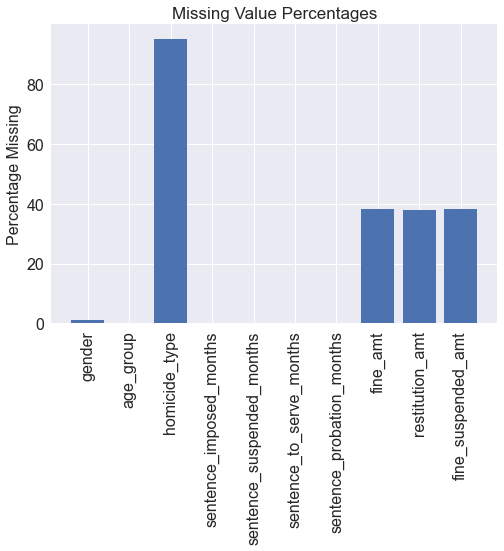

In [517]:
# Create visualization for presentation purpose
hhh = prison_df.isnull().sum().compute() * 100 / prison_df.isnull().count().compute()
hhh = hhh[hhh[:] > 0]
plt.bar(hhh.index, hhh[:])
plt.xticks(rotation = 90, size = 16)
plt.yticks(size = 16)
plt.title('Missing Value Percentages', size = 17)
plt.ylabel('Percentage Missing', size = 16)
plt.show()

In [518]:
# Gender missing values (will assign a 3rd class to avoid dropping data)
prison_df.gender = prison_df.gender.fillna(value = 'not_recorded')

# homicide_type (missing values are due to the charge not being homicide related)
prison_df.homicide_type = prison_df.homicide_type.fillna(value = 'not_homicide')

# The 'sentence_suspended_months' column has a value of zero throughout column
# The 'sentence_probation_months' is applicable to a sentence type not of interest
# The 'sentence_imposed_months' is an exact duplicate column of the target column
# The above three columns will be dropped
prison_df = prison_df.drop(columns = ['sentence_suspended_months', 'sentence_probation_months', 'sentence_imposed_months' ])

# Fines and fees columns have missing values have 37% of values missing
# These values will be replaced by zeros
prison_df.fine_amt = prison_df.fine_amt.fillna(value = 0)
prison_df.restitution_amt = prison_df.restitution_amt.fillna(value = 0)
prison_df.fine_suspended_amt = prison_df.fine_suspended_amt.fillna(value = 0)

In [519]:
# Few missing values remain
miss_vals = prison_df.isnull().sum() * 100 / prison_df.isnull().count()
miss_vals.compute()

objectid                    0.000000
rid                         0.000000
generic_case_id             0.000000
generic_offender_id         0.000000
charge_number               0.000000
sentence_year               0.000000
race                        0.000000
gender                      0.000000
age_group                   0.243022
offense                     0.000000
offense_type                0.000000
homicide_type               0.000000
offense_severity_group      0.000000
sentence_type               0.000000
sentence_to_serve_months    0.272480
vvca_amt                    0.000000
fine_amt                    0.000000
restitution_amt             0.000000
fine_suspended_amt          0.000000
dtype: float64

In [520]:
# Remaining missing values are in the age_group column and target column - get total percentage missing
print('Age Group Missing Value Percentage:')
print(((prison_df.age_group.shape[0] - prison_df.age_group.value_counts().sum()) * 100 / prison_df.age_group.shape[0]).compute())
print('Sentence to Serve Months Missing Value Percentage:')
print(((prison_df.sentence_to_serve_months.shape[0] - prison_df.sentence_to_serve_months.value_counts().sum()) * 100 / prison_df.sentence_to_serve_months.shape[0]).compute())

# Very small percentage of missing values -> Drop missing age and empty sentence term values
# Missing values in target correspond to Life sentence type, will drop the 37 missing rows
prison_df = prison_df.dropna()

Age Group Missing Value Percentage:
0.24302231386700052
Sentence to Serve Months Missing Value Percentage:
0.2724795640326976


In [521]:
# Verify data has no more missing values
miss_vals = prison_df.isnull().sum() * 100 / prison_df.isnull().count()
miss_vals.compute()

objectid                    0.0
rid                         0.0
generic_case_id             0.0
generic_offender_id         0.0
charge_number               0.0
sentence_year               0.0
race                        0.0
gender                      0.0
age_group                   0.0
offense                     0.0
offense_type                0.0
homicide_type               0.0
offense_severity_group      0.0
sentence_type               0.0
sentence_to_serve_months    0.0
vvca_amt                    0.0
fine_amt                    0.0
restitution_amt             0.0
fine_suspended_amt          0.0
dtype: float64

**Cleaning Data** - Outliers


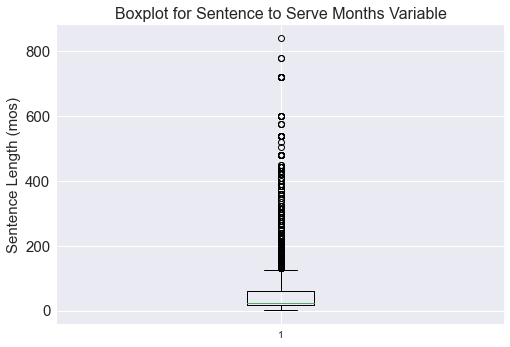

In [522]:
# Outliers and Distribution of Target Value
plt.boxplot(x = prison_df.sentence_to_serve_months)
plt.yticks(size = 15)
plt.title('Boxplot for Sentence to Serve Months Variable', size = 16)
plt.ylabel('Sentence Length (mos)', size = 15)
plt.show()

Inspect the distribution of the target variable

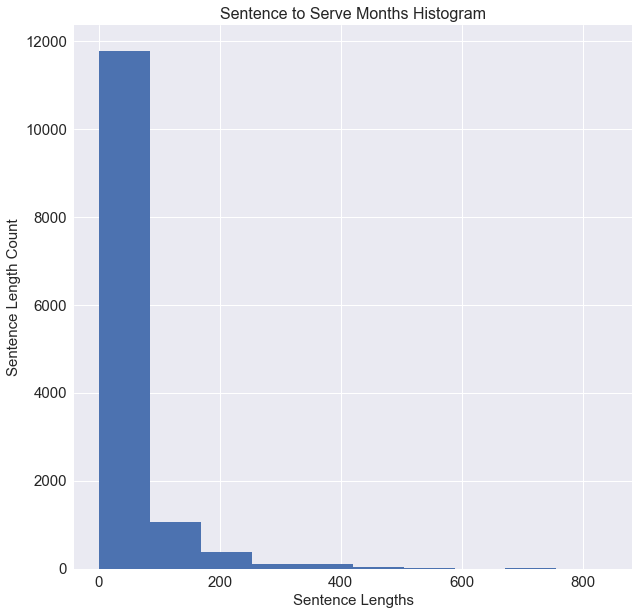

In [523]:
# Target distribution
plt.figure(figsize = (10, 10))
plt.hist(prison_df.sentence_to_serve_months)
plt.title('Sentence to Serve Months Histogram', size = 16)
plt.ylabel('Sentence Length Count', size = 15)
plt.xlabel('Sentence Lengths', size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

Heavily right skewed distribution

Apply boxcox transformation to remedy skewness

In [524]:
# Transform the sentence to serve months with boxcox and check for normality
log_sentence = da.log(prison_df.sentence_to_serve_months)

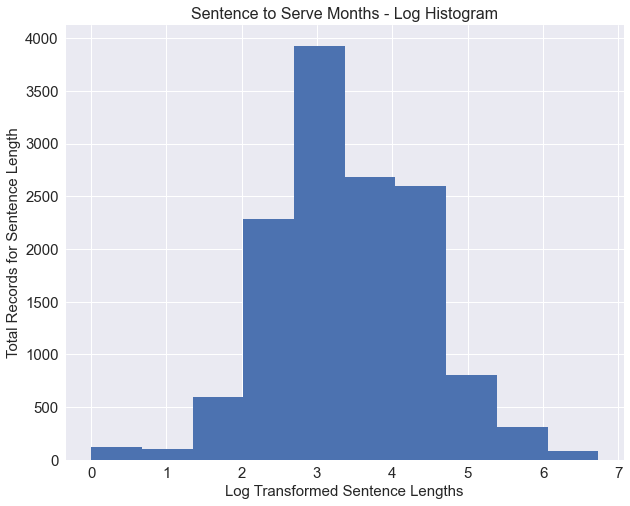

In [525]:
# Add boxcox sentence feature to dataframe
prison_df['log_sentence'] = log_sentence

# Plot histogram
plt.figure(figsize = (10, 8))
plt.hist(prison_df.log_sentence)
plt.title('Sentence to Serve Months - Log Histogram', size = 16)
plt.ylabel('Total Records for Sentence Length', size = 15)
plt.xlabel('Log Transformed Sentence Lengths', size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

In [526]:
# Adding a 1 to all values to avoid divide by zero errors when testing for normality
log_for_norm_test = (log_sentence.compute() + 1)

# Assign a variable to each test performed for ‘subscribers’
jb_stats = jarque_bera(log_for_norm_test)
norm_stats = normaltest(log_for_norm_test)

# Print results of tests
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 458.29302833254405 and p value is 0.0
Normality test statistics is 229.65455774094147 and p value is 1.3525284670339225e-50


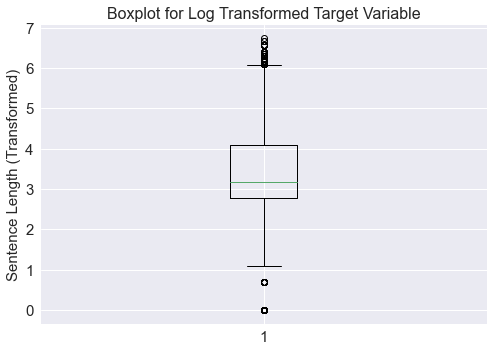

In [527]:
# Outliers and Distribution of Target Value with Boxcox transformation
plt.boxplot(x = prison_df.log_sentence.compute())
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.title('Boxplot for Log Transformed Target Variable', size = 16)
plt.ylabel('Sentence Length (Transformed)', size = 15)
plt.show()

Outliers left in data

**Data Exploration**

In [528]:
# preview data
prison_df.head()

,objectid,rid,generic_case_id,generic_offender_id,charge_number,sentence_year,race,gender,age_group,offense,offense_type,homicide_type,offense_severity_group,sentence_type,sentence_to_serve_months,vvca_amt,fine_amt,restitution_amt,fine_suspended_amt,log_sentence
15,16,16,8567971,8258401,4,2018,Black,M,22-30,POS. F/A DURING VIO/DAG OFF,Weapon,not_homicide,M5,Incarceration,1.0,100,0.0,0.0,0.0,0.0
16,17,17,8567971,8258401,7,2018,Black,M,22-30,POS. F/A DURING VIO/DAG OFF,Weapon,not_homicide,M5,Incarceration,1.0,100,0.0,0.0,0.0,0.0
17,18,18,8567971,8258401,10,2018,Black,M,22-30,POS. F/A DURING VIO/DAG OFF,Weapon,not_homicide,M5,Incarceration,1.0,100,0.0,0.0,0.0,0.0
18,19,19,8567971,8258401,11,2018,Black,M,22-30,CARRY PISTOL W/O LIC-OUTSIDE H0ME/BUSINESS,Weapon,not_homicide,M8,Incarceration,1.0,100,0.0,0.0,0.0,0.0
19,20,20,8567971,8258401,12,2018,Black,M,22-30,ADW GUN,Violent,not_homicide,M6,Incarceration,1.0,100,0.0,0.0,0.0,0.0


Examples of crimes in each severity group

M1 = Felony First Degree Murder

M2 = Second Degree Murder and First Degree Sexual Abuse

M3 = Burglary One, Voluntary Manslaughter, Kidnapping, First Degree Child Sex Abuse

M4 = Aggravated Assault Knowingly, Voluntary Manslaughter, Soliciting Murder

M5 = Poss Firearm During Crime of Violence, Obstructing Justice, Robbery, Kidnapping, Involuntary Manslaughter

M6 = Assault With A Dangerous Weapon, Robbery, Arson, 
M7 = 
M8 = 


**Data Exploration** - Continuous Variables

In [529]:
prison_df.dtypes.value_counts()

object     8
int64      7
float64    5
dtype: int64

Continuous variables below will not be considered.

* objectid == rid, will eliminate both since not related to data (just an index for the table)

*  generic_case_id is an anonymized numer to represent the real case numbers

In [530]:
# Will eliminate continuous variables as listed above.
prison_df = prison_df.drop(columns = ['objectid', 'rid', 'generic_case_id'])

* generic_offender_id and charge_number - may be useful to create a new column for offenders with multiple crimes

In [531]:
# Inspect both generic_offender_id and charge_number columns to see if they both  
# represent the same information regarding the number of individuals that are repeated
print(prison_df.generic_offender_id.value_counts().compute().sum() == prison_df.charge_number.value_counts().compute().sum())

# Keep only one of the columns (dropping charge_number)
prison_df = prison_df.drop(columns = ['charge_number'])

True


Changing sentence_year into a categorical field instead of continuous

In [532]:
# Convert sentence_year to an object
prison_df['sentence_year'] = prison_df['sentence_year'].astype(object)

Continuous variable distributions and correlations

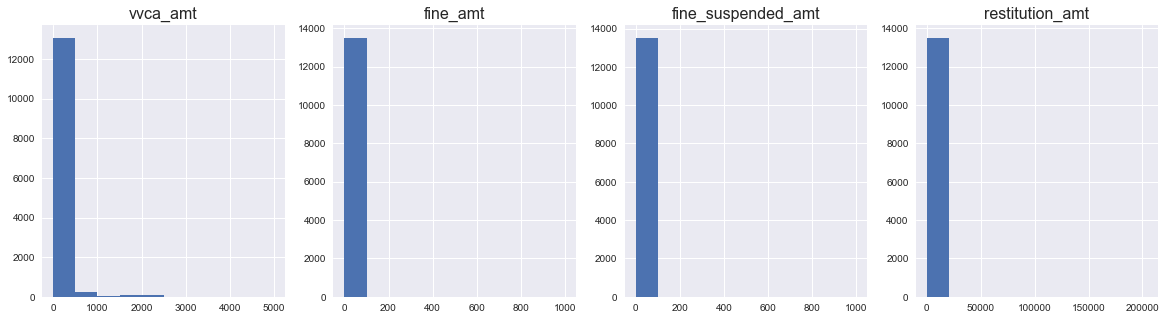

In [533]:
# Distribution of continuous variables
plt.figure(figsize = (20,5))

plt.subplot(1,4,1)
plt.hist(prison_df.vvca_amt.compute())
plt.title('vvca_amt', size = 16)

plt.subplot(1,4,2)
plt.hist(prison_df.fine_amt.compute())
plt.title('fine_amt', size = 16)

plt.subplot(1,4,3)
plt.hist(prison_df.fine_suspended_amt.compute())
plt.title('fine_suspended_amt', size = 16)

plt.subplot(1,4,4)
plt.hist(prison_df.restitution_amt.compute())
plt.title('restitution_amt', size = 16)

plt.show()

Heavily right skewed continuous variables

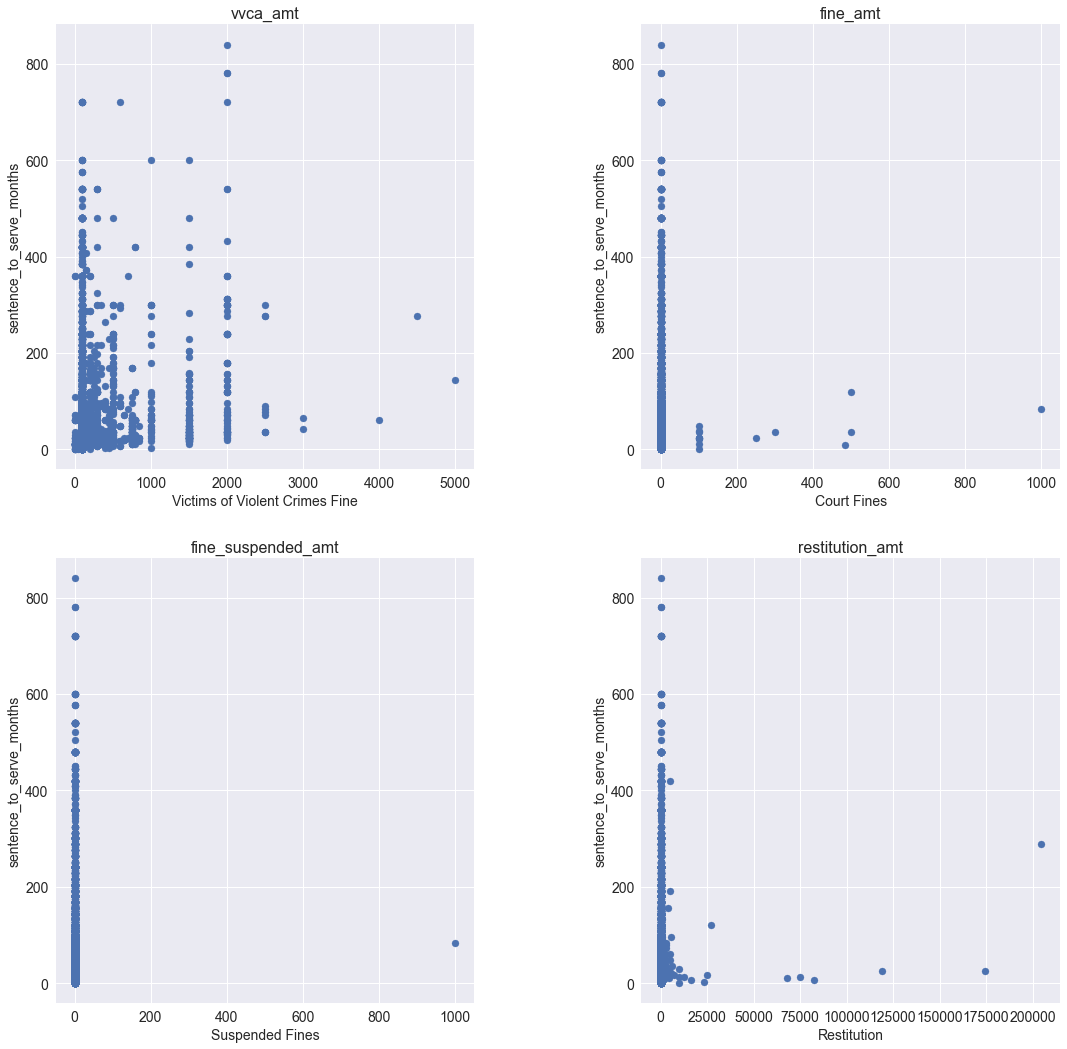

In [534]:
# Scatter plot of all continuous
plt.figure(figsize = (18,18))

plt.subplot(2, 2, 1)
plt.scatter(prison_df.vvca_amt.compute(), prison_df.sentence_to_serve_months.compute())
plt.title('vvca_amt', size = 16)
plt.ylabel('sentence_to_serve_months', size = 14)
plt.xlabel('Victims of Violent Crimes Fine', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.subplot(2, 2, 2)
plt.scatter(prison_df.fine_amt.compute(), prison_df.sentence_to_serve_months.compute())
plt.title('fine_amt', size = 16)
plt.ylabel('sentence_to_serve_months', size = 14)
plt.xlabel('Court Fines', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.subplot(2, 2, 3)
plt.scatter(prison_df.fine_suspended_amt.compute(), prison_df.sentence_to_serve_months.compute())
plt.title('fine_suspended_amt', size = 16)
plt.ylabel('sentence_to_serve_months', size = 14)
plt.xlabel('Suspended Fines', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.subplot(2 , 2, 4)
plt.scatter(prison_df.restitution_amt.compute(), prison_df.sentence_to_serve_months.compute())
plt.title('restitution_amt', size = 16)
plt.ylabel('sentence_to_serve_months', size = 14)
plt.xlabel('Restitution', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.subplots_adjust(wspace = .4)
plt.show()

In [535]:
# Sort from highest correlated to least
correlations = prison_df.corr()['log_sentence'].compute().sort_values(ascending = False)
print('Most positive correlations:\n', correlations)

Most positive correlations:
 log_sentence                1.000000
sentence_to_serve_months    0.779078
vvca_amt                    0.142896
fine_suspended_amt          0.009024
fine_amt                    0.005212
restitution_amt             0.000318
generic_offender_id        -0.005006
Name: log_sentence, dtype: float64


Minor correlation exists only in vvca_amt variable. Will include variables in initial models

In [536]:
# Transforming each of the fine columns as well, may remove if it does not improve model performance
# add 1 to each value for boxcox transformarion
prison_df['vvca_amt'] = prison_df['vvca_amt'] + 1
prison_df['fine_amt'] = prison_df['fine_amt'] + 1
prison_df['restitution_amt'] = prison_df['restitution_amt'] + 1
prison_df['fine_suspended_amt'] = prison_df['fine_suspended_amt'] + 1

log_vvca = da.log(prison_df.vvca_amt)
log_fine = da.log(prison_df.fine_amt)
log_restitution = da.log(prison_df.restitution_amt)
log_fine_susp = da.log(prison_df.fine_suspended_amt)

prison_df['log_vvca'] = log_vvca
prison_df['log_fine'] = log_fine
prison_df['log_restitution'] = log_restitution
prison_df['log_fine_susp'] = log_fine_susp

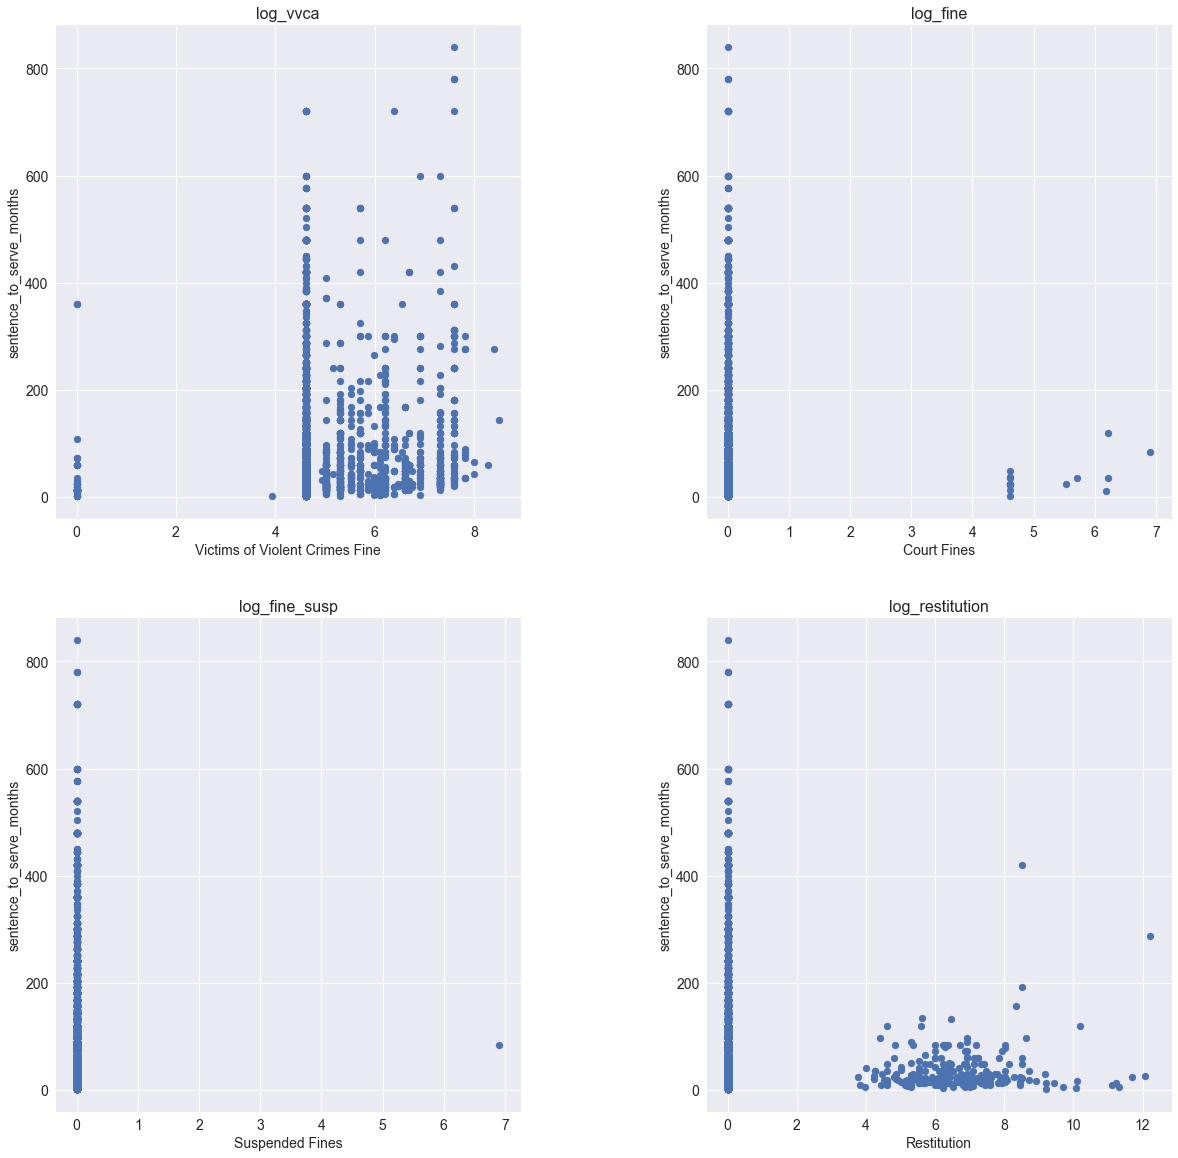

In [537]:
# Scatter plot of all continuous variables after transform
plt.figure(figsize = (20, 20))

plt.subplot(2, 2, 1)
plt.scatter(prison_df.log_vvca.compute(), prison_df.sentence_to_serve_months.compute())
plt.title('log_vvca', size = 16)
plt.ylabel('sentence_to_serve_months', size = 14)
plt.xlabel('Victims of Violent Crimes Fine', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.subplot(2, 2, 2)
plt.scatter(prison_df.log_fine.compute(), prison_df.sentence_to_serve_months.compute())
plt.title('log_fine', size = 16)
plt.ylabel('sentence_to_serve_months', size = 14)
plt.xlabel('Court Fines', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.subplot(2, 2, 3)
plt.scatter(prison_df.log_fine_susp.compute(), prison_df.sentence_to_serve_months.compute())
plt.title('log_fine_susp', size = 16)
plt.ylabel('sentence_to_serve_months', size = 14)
plt.xlabel('Suspended Fines', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.subplot(2, 2, 4)
plt.scatter(prison_df.log_restitution.compute(), prison_df.sentence_to_serve_months.compute())
plt.title('log_restitution', size = 16)
plt.ylabel('sentence_to_serve_months', size = 14)
plt.xlabel('Restitution', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.subplots_adjust(wspace = .4)
plt.show()

As expected the fines are very weakly correlated to one another and to the target. Will leave them in to see if they improve predictions in lower term sentences.

**Data Exploration** - Categorical Variables

In [538]:
# Get a count of categorical variables in each categorical feature
prison_df.select_dtypes('object').compute().nunique().sort_values(ascending = False)

offense                   195
offense_severity_group     13
sentence_year               9
age_group                   8
offense_type                7
homicide_type               5
race                        5
gender                      3
sentence_type               1
dtype: int64

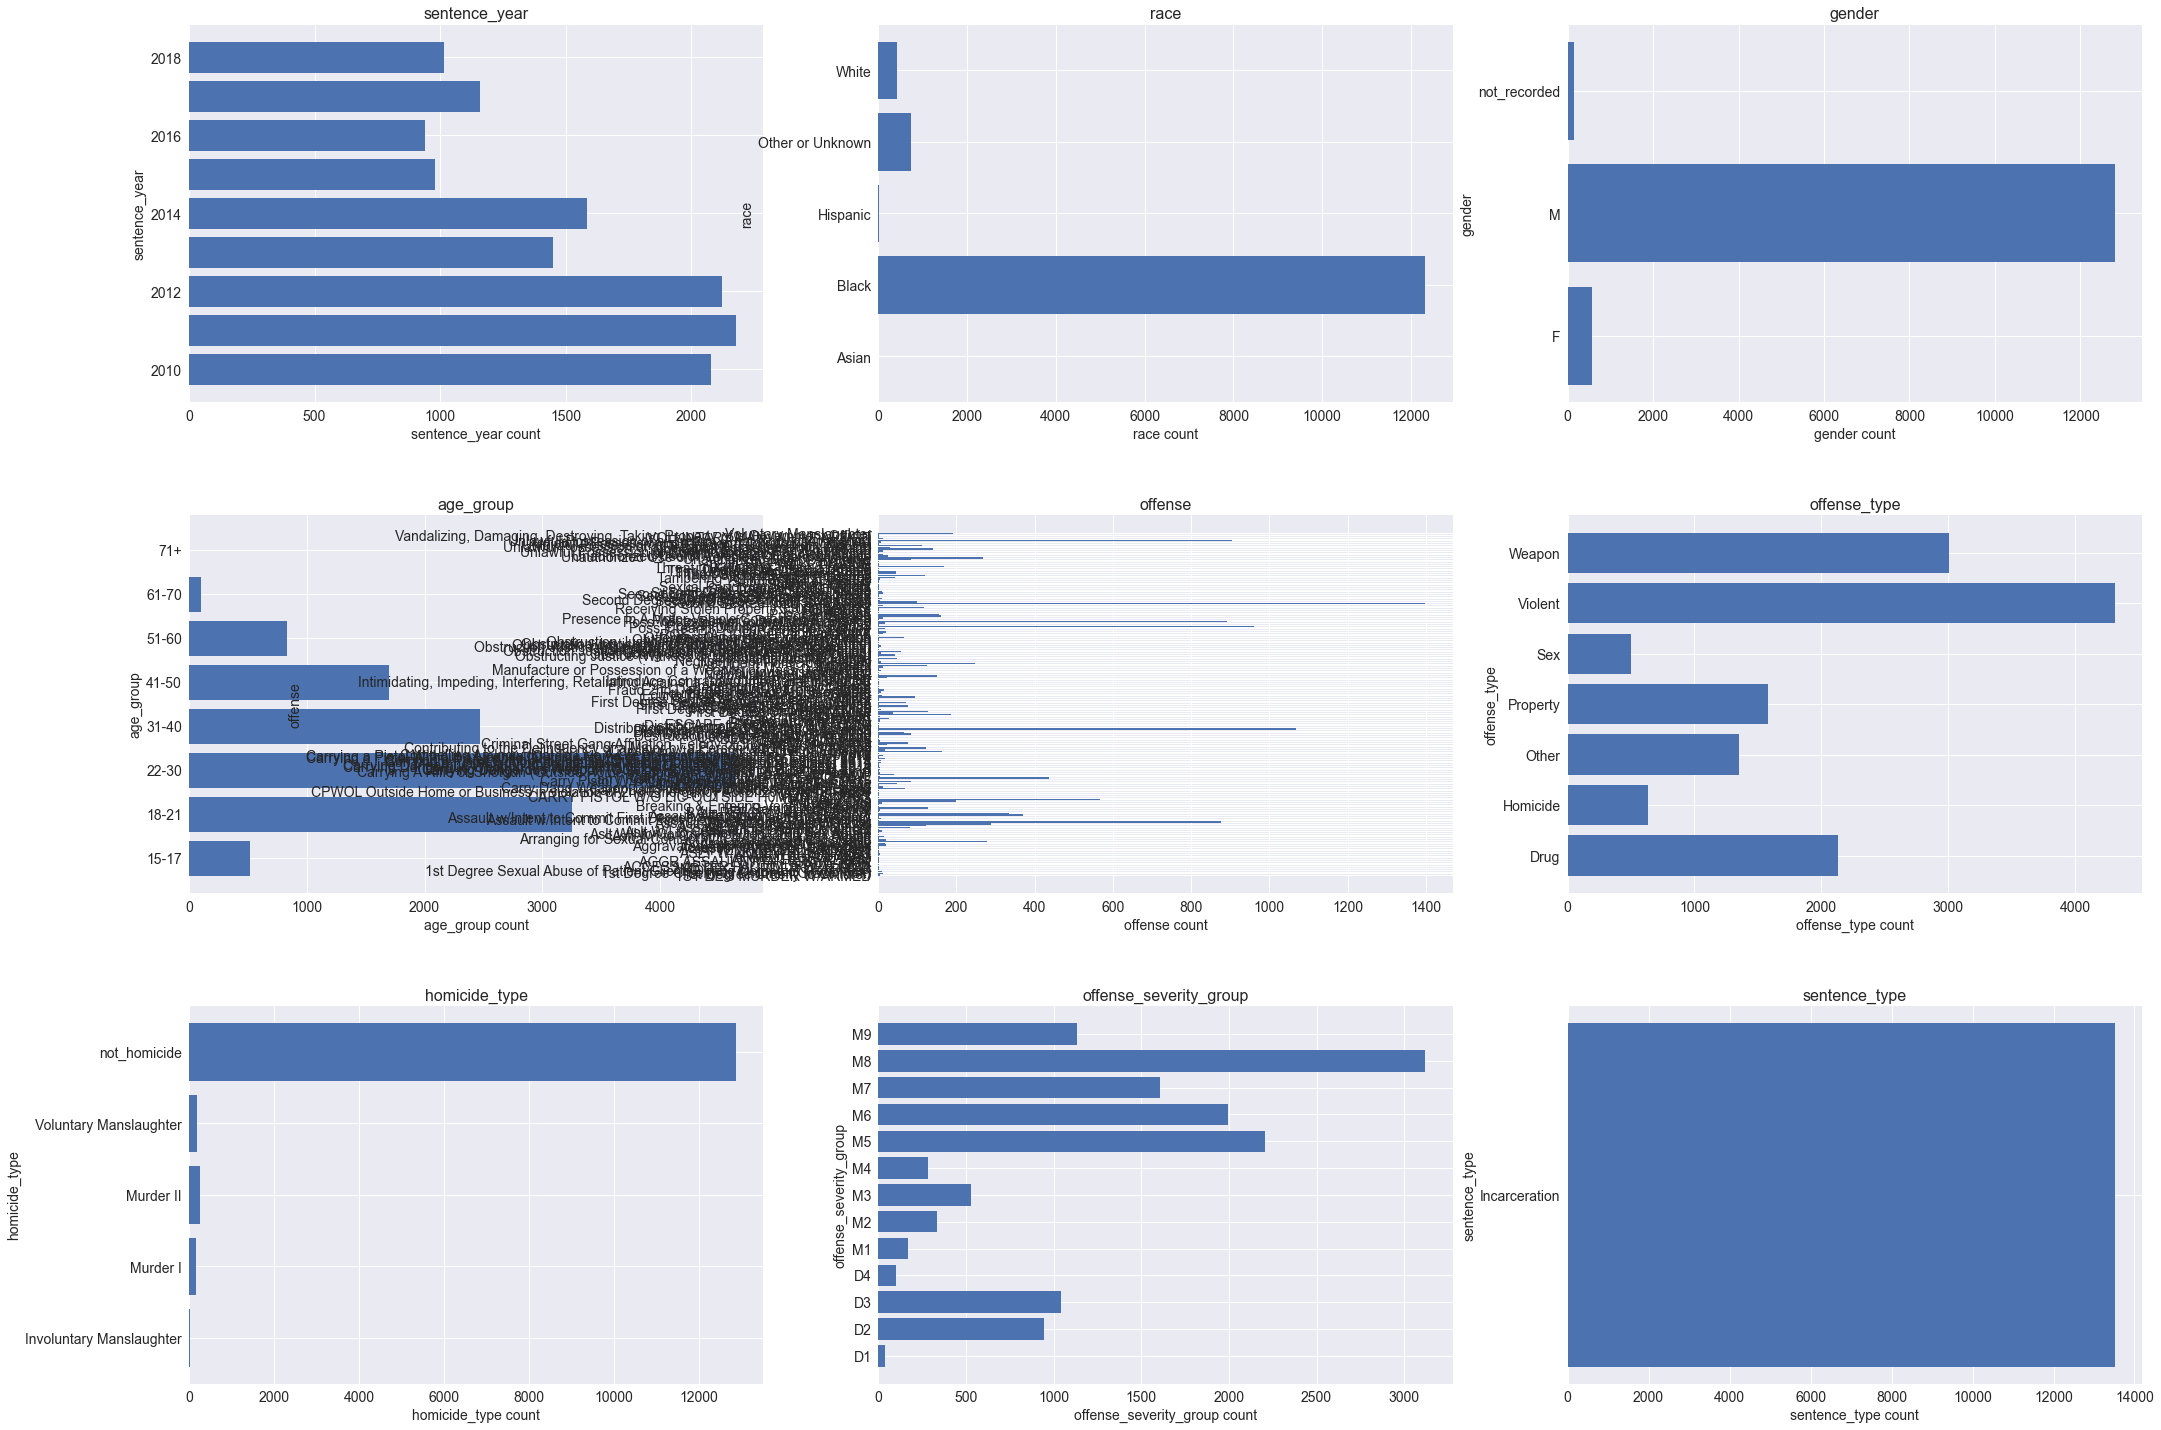

In [539]:
# Categorical Data Exploration

# create a list of all category columns
categoricals = list(prison_df.select_dtypes(include = 'object').columns)

# Loop through category list and plot the total instances of each category variable
plt.figure(figsize = (35, 25))
i=1
for categs in categoricals:
  plt.subplot(3, 3, i)
  plt.barh(prison_df.groupby(categs)[categs].count().index.compute(),
           prison_df.groupby(categs)[categs].count().compute())
  plt.title(categs, size = 16)
  plt.xticks(size = 14)
  plt.yticks(size = 14)
  plt.xlabel(categs + ' count', size = 14)
  plt.ylabel(categs, size = 14)
  i = i + 1
plt.subplots_adjust(wspace = .2, hspace = .3)
plt.show()

Possible reduction of dimensions in the following categories:
* Race, gender, offense, and homicide type

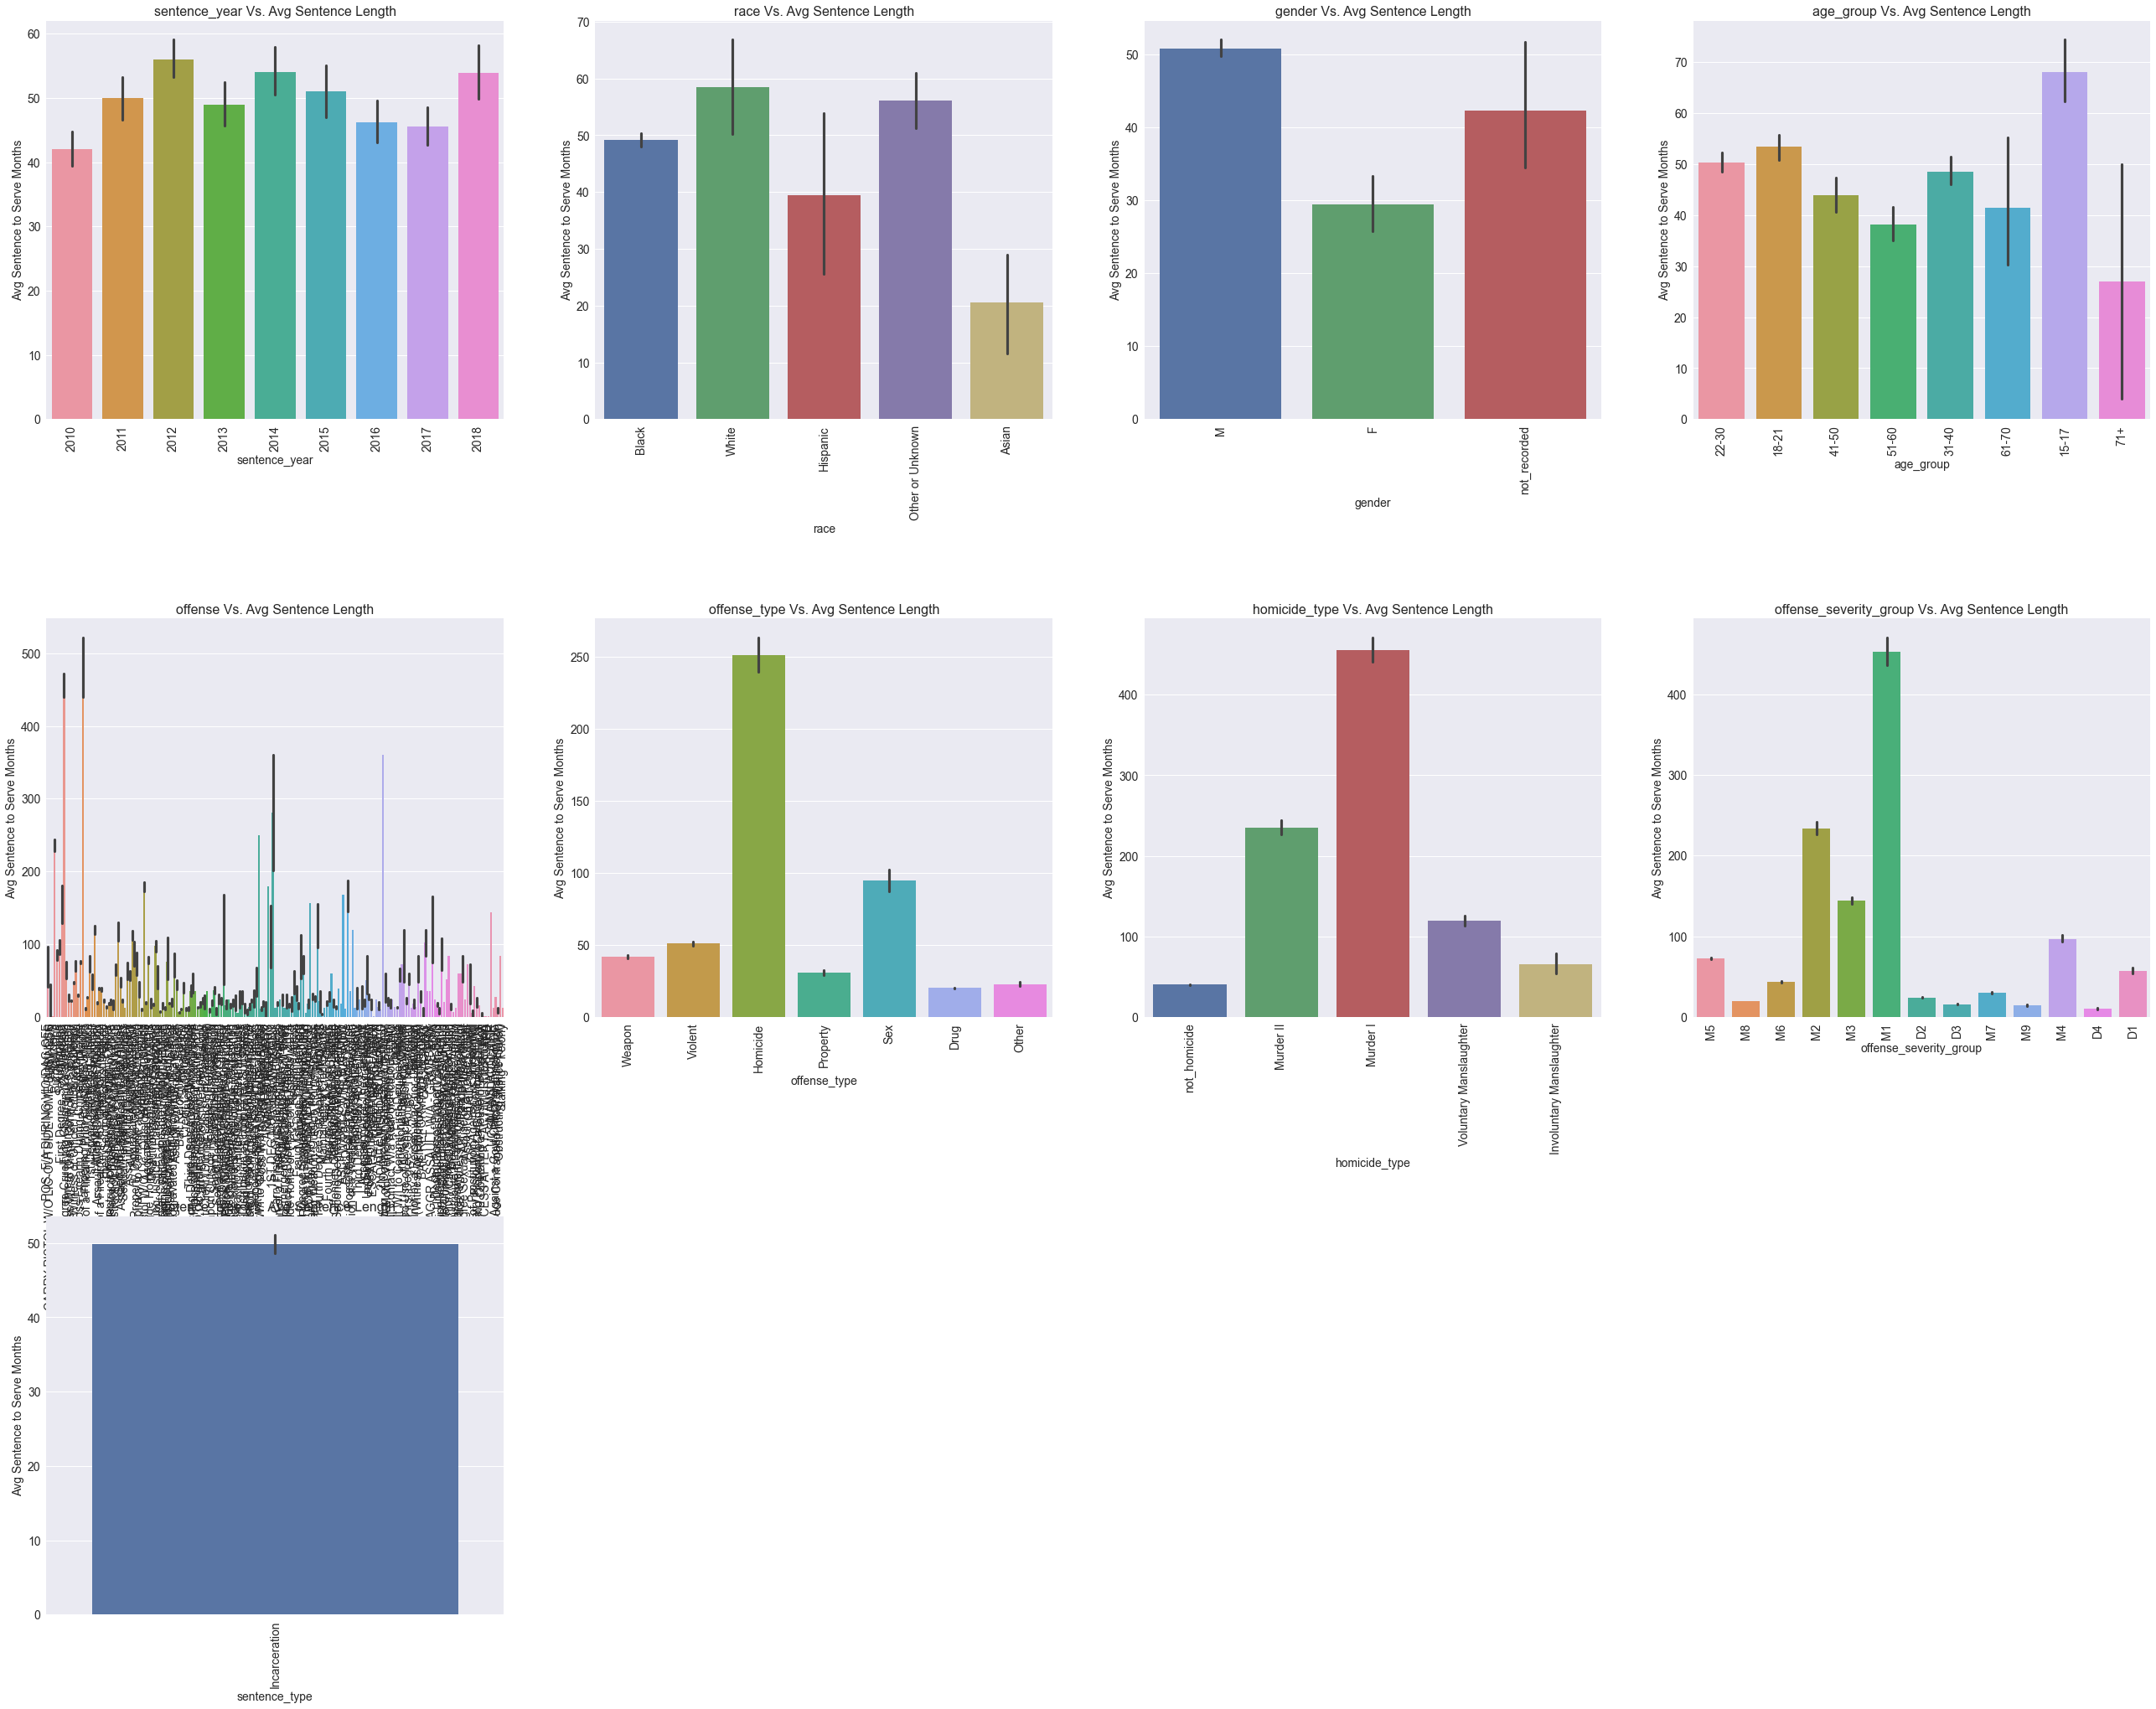

In [540]:
# Bivariate analysis, categoricals vs target mean

# Loop through the category columns and plot each category variable and
# the corresponding average sentence in months
plt.figure(figsize = (45, 35))
i=1
for categs in categoricals:
  plt.subplot(3,4,i)
  sns.barplot(prison_df[categs].compute(), prison_df.sentence_to_serve_months.compute())
  plt.title(categs + ' Vs. Avg Sentence Length', size = 16)
  plt.xticks(rotation = 90, size = 14)
  plt.yticks(size = 14)
  plt.xlabel(categs, size = 14)
  plt.ylabel('Avg Sentence to Serve Months', size = 14)
  i = i + 1
plt.subplots_adjust(wspace = .2, hspace = .5)
plt.show()

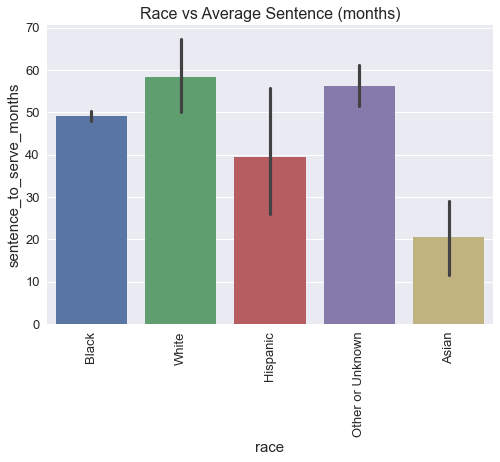

In [541]:
  # Plot of individual bivariate from above group
  sns.barplot(prison_df.race.compute(), prison_df.sentence_to_serve_months.compute())
  plt.title('Race vs Average Sentence (months)', size = 16)
  plt.xticks(rotation = 90, size = 13)
  plt.yticks(size = 13)
  plt.xlabel('race', size = 15)
  plt.ylabel('sentence_to_serve_months', size = 15)
  plt.show()

# **Feature Engineering**

* Reducing offense column into categories based on avg sentence

In [542]:
offense_count = prison_df.groupby('offense')['sentence_to_serve_months'].mean().compute()

In [543]:
offense_count = offense_count.sort_values(ascending = False)

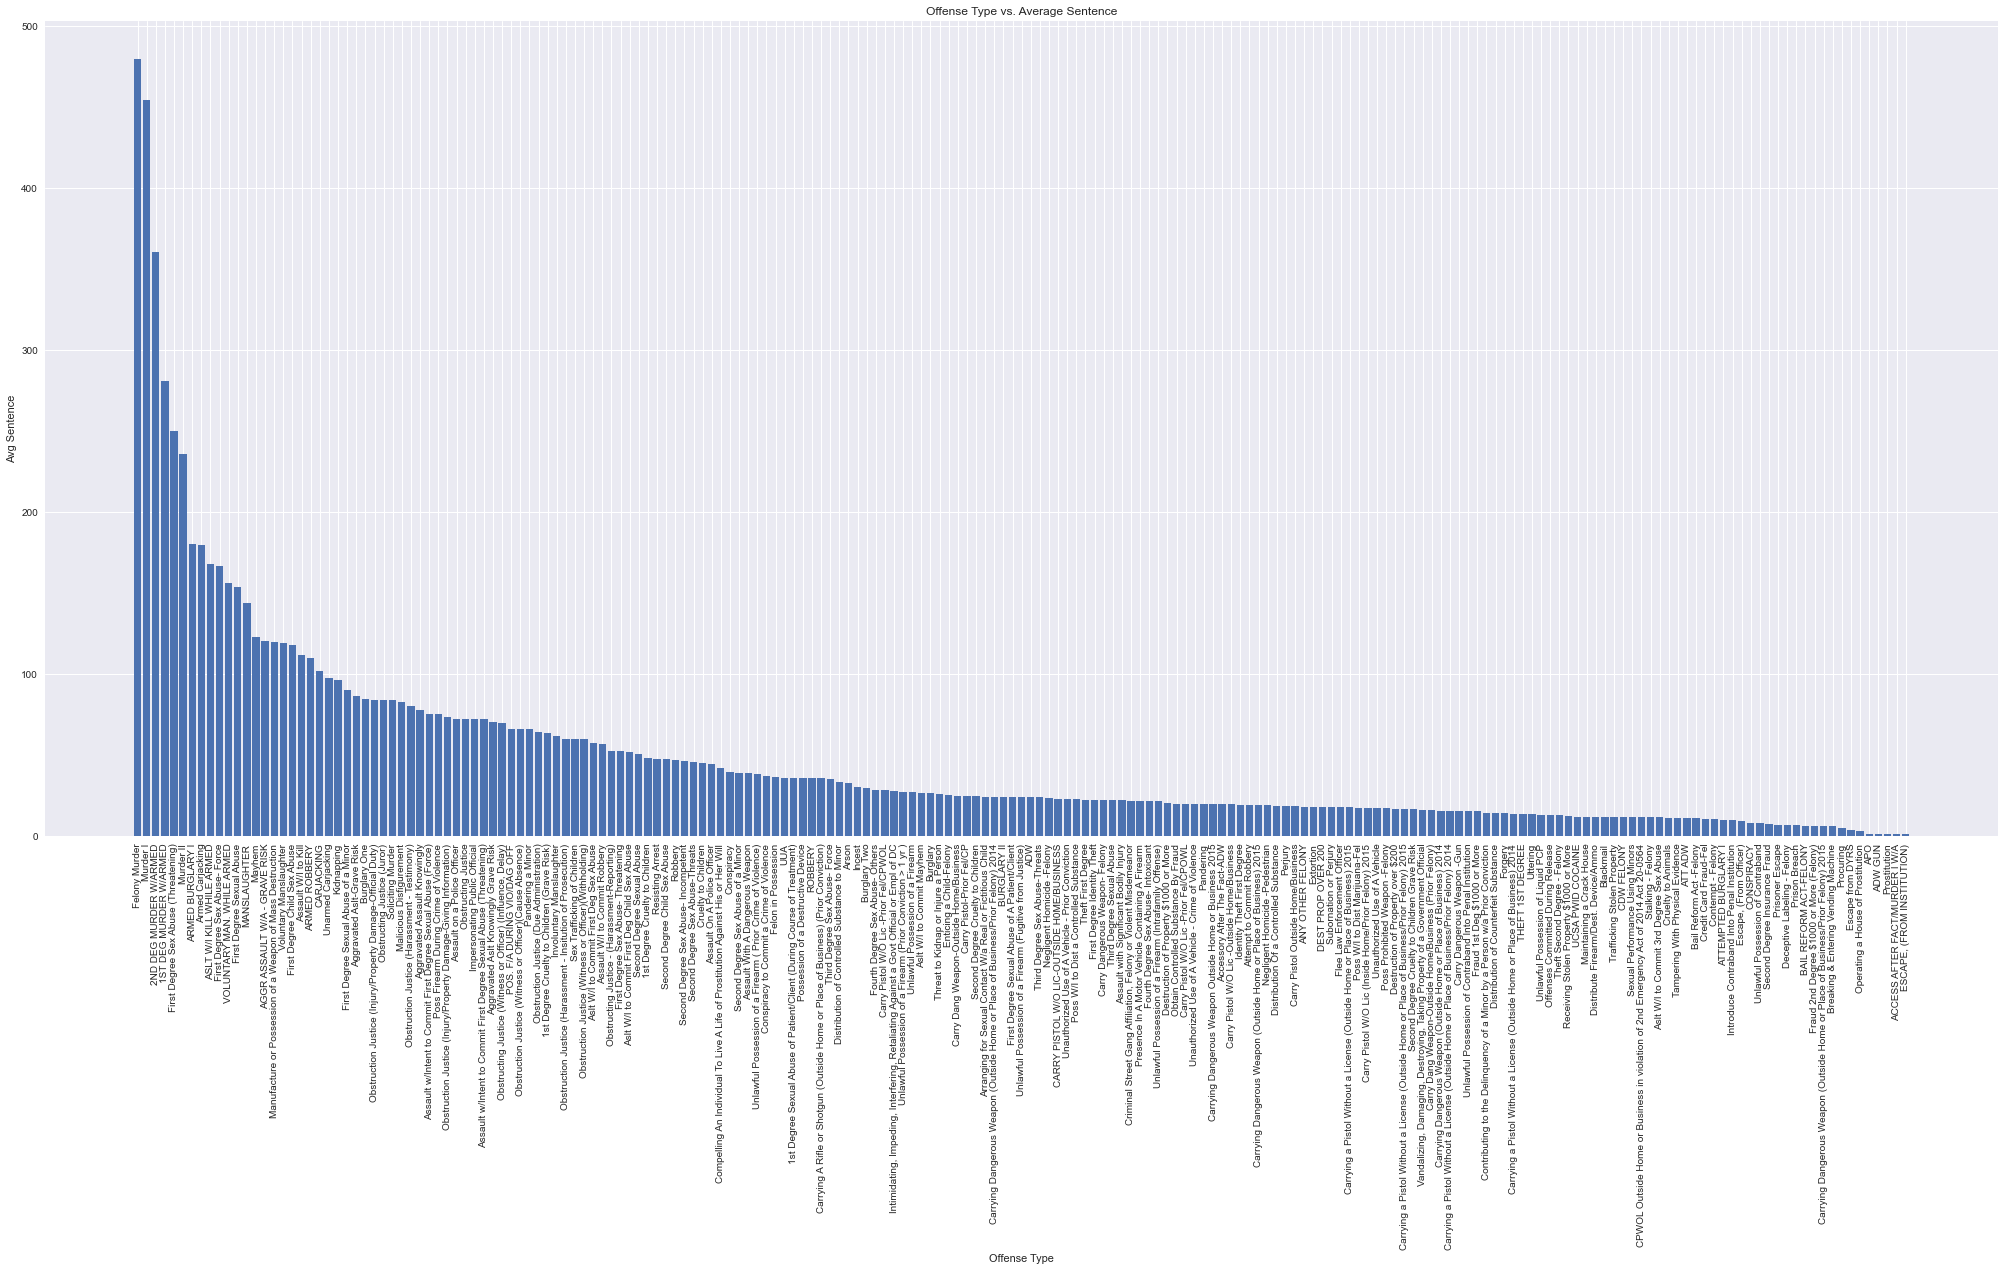

In [544]:
# Plot a offenses on x-axis with average term length for each offense category in decreasing order
# Identify significant drops to create new categories to reduce dimensions 

plt.figure(figsize = (35, 15))
plt.bar(offense_count.index, offense_count)
plt.xticks(rotation = 90)
plt.title('Offense Type vs. Average Sentence')
plt.ylabel('Avg Sentence')
plt.xlabel('Offense Type')
plt.show()

Creating new categories of offense types to reduce dimensionality, based on drops in average sentences observed in plot above.

In [545]:
# Break the over 450 types of offenses down into 12 levels
f = (lambda x: 'severe_hi' if x >= 600 else 'severe_lo' if 500 <= x < 600 else 'serious_hi' if 320 <= x < 500 else 
     'serious_mid' if 180 <= x < 320 else 'serious_lo' if 120 <= x < 180 else 'major_hi' if 100 <= x < 120 else 
     'major_mid' if 80 <= x < 100 else 'major_lo' if 60 <= x < 80 else 'minor_hi' if 40 <= x < 60 else 
     'minor_mid' if 20 <= x < 40 else 'minor_lo' if 10 <= x < 20 else 'minimum')

prison_df['offense_lvl'] = prison_df.sentence_to_serve_months.apply(f)

In [546]:
# Verify offense types have been reduced to 12 levels
prison_df.offense_lvl.value_counts().compute()

minor_mid      4333
minor_lo       3420
major_lo       1656
minimum        1003
minor_hi        970
major_mid       688
serious_lo      494
serious_mid     477
major_hi        273
serious_hi      156
severe_lo        22
severe_hi        17
Name: offense_lvl, dtype: int64

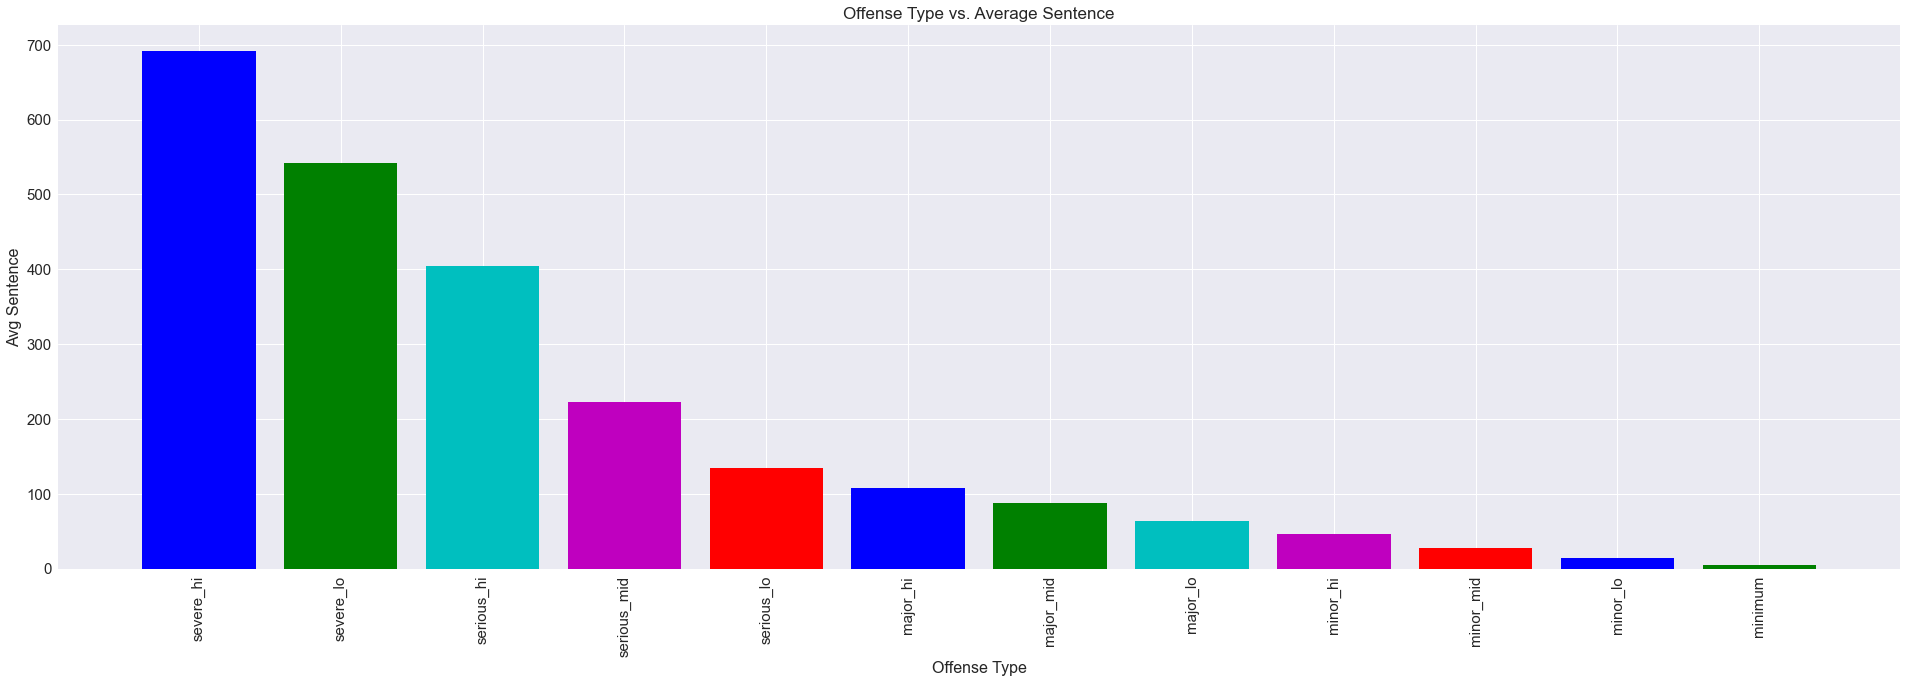

In [547]:
# Plot reduced dimension offense feature
offense_count = prison_df.groupby('offense_lvl')['sentence_to_serve_months'].mean().compute()

offense_count = offense_count.sort_values(ascending = False)

plt.figure(figsize = (33, 10))
plt.bar(offense_count.index, offense_count, color = ('b','g','c', 'm', 'r') )
plt.xticks(rotation = 90, size = 15)
plt.yticks(size = 15)
plt.title('Offense Type vs. Average Sentence', size = 17)
plt.ylabel('Avg Sentence', size = 16)
plt.xlabel('Offense Type', size = 16)
plt.show()

Many duplicate offender IDs were identified in data. Will add a new column to detect duplicate offender ID's and assign a multiple_crime boolean value.

In [548]:
# Create a dataframe for use in non-linear regression models
prison_nonlin_df = prison_df

In [549]:
# Handle object datatypes prior to one-hot encoding
prison_df = prison_df.categorize()

In [550]:
# New list of categorical values of interest
categoricals = ['sentence_year', 'race', 'gender', 'age_group', 'offense_lvl', 'offense_type', 'homicide_type', 'offense_severity_group', 'sentence_type']

# Convert categorical columns into numeric
for feats in categoricals:
  prison_df = dd.concat([prison_df, dd.get_dummies(prison_df[feats], prefix= str(feats), drop_first = True)], axis = 1)

In [551]:
# Verify new dataframe
prison_df.head()

,generic_offender_id,sentence_year,race,gender,age_group,offense,offense_type,homicide_type,offense_severity_group,sentence_type,...,offense_severity_group_M2,offense_severity_group_M3,offense_severity_group_M1,offense_severity_group_D2,offense_severity_group_D3,offense_severity_group_M7,offense_severity_group_M9,offense_severity_group_M4,offense_severity_group_D4,offense_severity_group_D1
15,8258401,2018,Black,M,22-30,POS. F/A DURING VIO/DAG OFF,Weapon,not_homicide,M5,Incarceration,...,0,0,0,0,0,0,0,0,0,0
16,8258401,2018,Black,M,22-30,POS. F/A DURING VIO/DAG OFF,Weapon,not_homicide,M5,Incarceration,...,0,0,0,0,0,0,0,0,0,0
17,8258401,2018,Black,M,22-30,POS. F/A DURING VIO/DAG OFF,Weapon,not_homicide,M5,Incarceration,...,0,0,0,0,0,0,0,0,0,0
18,8258401,2018,Black,M,22-30,CARRY PISTOL W/O LIC-OUTSIDE H0ME/BUSINESS,Weapon,not_homicide,M8,Incarceration,...,0,0,0,0,0,0,0,0,0,0
19,8258401,2018,Black,M,22-30,ADW GUN,Violent,not_homicide,M6,Incarceration,...,0,0,0,0,0,0,0,0,0,0


**Feature Selection** - Setup dataframe for modeling

In [552]:
prison_df = prison_df.drop(columns = ['sentence_year', 'race', 'gender', 'age_group', 'offense', 'offense_lvl', 
                                      'offense_type', 'homicide_type', 'offense_severity_group', 'sentence_type'], axis = 1)

In [553]:
prison_df = prison_df.drop(columns = ['generic_offender_id', 'sentence_to_serve_months', 'vvca_amt', 'fine_amt', 
                                      'restitution_amt', 'fine_suspended_amt'], axis = 1)

# **Modelling**

**Regression Models Employed:**
* Linear Regression
* Random Forest

**Preparing Data for Models**
* Separate features(X) and labels(y)
* Create train and test sets


In [554]:
# Split features and target
X = prison_df.drop(columns = ['log_sentence'])
y = prison_df['log_sentence']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, test_size = 0.2, random_state = 2)

# Since our data can fit into memory to persist them to the RAM.
X_train.persist()
X_test.persist()
y_train.persist()
y_test.persist()

Dask Series Structure:
npartitions=1
    float64
        ...
Name: log_sentence, dtype: float64
Dask Name: split, 1 tasks

In [555]:
# Verify split
print(X_train.shape[0].compute(), y_train.shape[0].compute(), X_test.shape[0].compute(), y_test.shape[0].compute())

10853 10853 2656 2656


# **Linear Regression Model**

In [556]:
# Create model
lr = LinearRegression()

with joblib.parallel_backend('dask'):
    # Train model
    lr.fit(X_train.values.compute(), y_train.values.compute())

In [557]:
# Predictions
preds_train = lr.predict(X_train.values.compute())
preds_test = lr.predict(X_test.values.compute())

In [558]:
# Score results
print("Training score is: ", r2_score(y_train.values.compute(), preds_train))
print("Test score is: ", r2_score(y_test.values.compute(), preds_test))

Training score is:  0.9438781720454256
Test score is:  0.9392383571827294


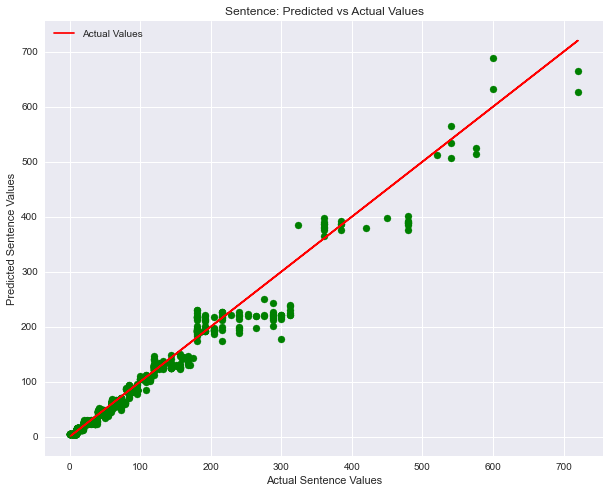

In [559]:
# Plot prediction vs actual
plt.figure(figsize = (10, 8))
plt.scatter(da.exp(y_test.compute()), da.exp(preds_test), c = 'g')
plt.plot(da.exp(y_test.compute()), da.exp(y_test.compute()), c = 'red', label = 'Actual Values')
plt.title('Sentence: Predicted vs Actual Values')
plt.xlabel('Actual Sentence Values')
plt.ylabel('Predicted Sentence Values')
plt.legend()
plt.show()

# **XGBoost**

In [564]:
import xgboost
# XGboost algorithm
xgb = xgboost.XGBRegressor()

# Train model with training data
with joblib.parallel_backend('dask'):
    xgb.fit(X_train.values.compute(), y_train.compute())

In [571]:
# Predictions
preds_trainxgb = xgb.predict(X_train.values.compute())
preds_testxgb = xgb.predict(X_test.values.compute())

In [572]:
# Score results
print("Training score is: ", r2_score(y_train.values.compute(), preds_trainxgb))
print("Test score is: ", r2_score(y_test.values.compute(), preds_testxgb))

Training score is:  0.9492233827029213
Test score is:  0.9218051508571367


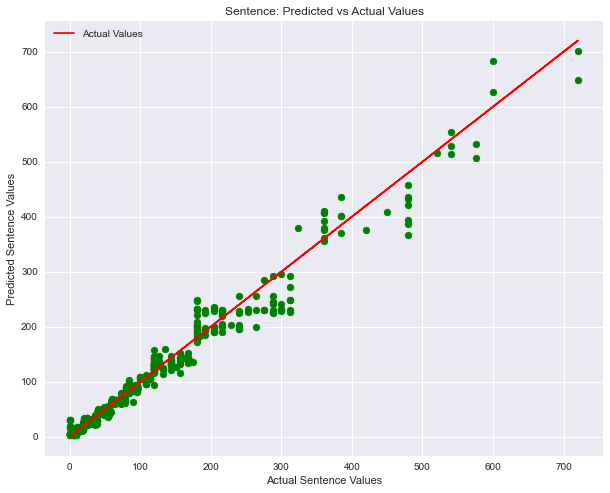

In [573]:
# Plot prediction vs actual
plt.figure(figsize = (10, 8))
plt.scatter(da.exp(y_test.compute()), da.exp(preds_testxgb), c = 'g')
plt.plot(da.exp(y_test.compute()), da.exp(y_test.compute()), c = 'red', label = 'Actual Values')
plt.title('Sentence: Predicted vs Actual Values')
plt.xlabel('Actual Sentence Values')
plt.ylabel('Predicted Sentence Values')
plt.legend()
plt.show()

# **Random Forest** 
Adjust table to drop first when creating dummies (Will remove race and multiple_crime)

In [423]:
prison_nonlin_df.head()

,generic_offender_id,sentence_year,race,gender,age_group,offense,offense_type,homicide_type,offense_severity_group,sentence_type,...,vvca_amt,fine_amt,restitution_amt,fine_suspended_amt,log_sentence,log_vvca,log_fine,log_restitution,log_fine_susp,offense_lvl
15,8258401,2018,Black,M,22-30,POS. F/A DURING VIO/DAG OFF,Weapon,not_homicide,M5,Incarceration,...,101,1.0,1.0,1.0,0.0,4.615121,0.0,0.0,0.0,minimum
16,8258401,2018,Black,M,22-30,POS. F/A DURING VIO/DAG OFF,Weapon,not_homicide,M5,Incarceration,...,101,1.0,1.0,1.0,0.0,4.615121,0.0,0.0,0.0,minimum
17,8258401,2018,Black,M,22-30,POS. F/A DURING VIO/DAG OFF,Weapon,not_homicide,M5,Incarceration,...,101,1.0,1.0,1.0,0.0,4.615121,0.0,0.0,0.0,minimum
18,8258401,2018,Black,M,22-30,CARRY PISTOL W/O LIC-OUTSIDE H0ME/BUSINESS,Weapon,not_homicide,M8,Incarceration,...,101,1.0,1.0,1.0,0.0,4.615121,0.0,0.0,0.0,minimum
19,8258401,2018,Black,M,22-30,ADW GUN,Violent,not_homicide,M6,Incarceration,...,101,1.0,1.0,1.0,0.0,4.615121,0.0,0.0,0.0,minimum


In [424]:
# Handle object datatypes prior to one-hot encoding
prison_nonlin_df = prison_nonlin_df.categorize()

In [425]:
# New list of categorical values of interest
categoricals = ['sentence_year', 'race', 'gender', 'age_group', 'offense_lvl', 'offense_type', 'homicide_type', 'offense_severity_group', 'sentence_type']

# Convert categorical columns into numeric
for feats in categoricals:
  prison_nonlin_df = dd.concat([prison_nonlin_df, dd.get_dummies(prison_nonlin_df[feats], prefix= str(feats), drop_first = True)], axis = 1)

In [426]:
# Drop columns not in use to clean dataframe
prison_nonlin_df = prison_nonlin_df.drop(columns = ['sentence_year', 'race', 'gender', 'age_group', 'offense', 'offense_lvl', 'offense_type', 'homicide_type',	'offense_severity_group', 'sentence_type'], axis = 1)
prison_nonlin_df = prison_nonlin_df.drop(columns = ['generic_offender_id', 'sentence_to_serve_months', 'vvca_amt', 'fine_amt', 'restitution_amt', 'fine_suspended_amt'], axis = 1)

In [427]:
# Split data
X2 = prison_nonlin_df.drop(columns = ['log_sentence'])
y2 = prison_nonlin_df.log_sentence

# Split data
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size = 0.80, test_size = 0.20, random_state = 2)

# Since our data can fit into memory to persist them to the RAM.
X2_train.persist()
X2_test.persist()
y2_train.persist()
y2_test.persist()

Dask Series Structure:
npartitions=1
    float64
        ...
Name: log_sentence, dtype: float64
Dask Name: split, 1 tasks

In [428]:
# Instantiate a model
rfr = RandomForestRegressor()

# Use parallelization to cross validate
with joblib.parallel_backend('dask'):
    cross_val = cross_validate(rfr, X2_train.values.compute(), y2_train.compute(), cv = 5)
print('\nCross Val for Random Forest:')
print(cross_val['test_score'])
print('\nCross Validation Mean Score: ')
print(cross_val['test_score'].mean())


Cross Val for Random Forest:
[0.92767829 0.93071736 0.92912829 0.9125726  0.88604765]

Cross Validation Mean Score: 
0.9172288395705035


In [431]:
# setting the parameters
param_grid = dict(n_estimators = np.arange(100, 120, 5), min_samples_leaf = np.arange(1, 3, 1), max_depth = np.arange(5, 25, 5), max_features = np.arange(30, 50, 5))

# Run cross validation with cv = 3
grid = GridSearchCV(rfr, param_grid, cv = 5, scoring = 'neg_mean_squared_error')

# Train model with best parameters
with joblib.parallel_backend('dask'):
    grid.fit(X2_train.values.compute(), y2_train.compute())

# Print the best parameters
print(grid.best_params_)

{'max_depth': 15, 'max_features': 45, 'min_samples_leaf': 1, 'n_estimators': 100}


In [432]:
# Predictions
preds_train2 = grid.predict(X2_train.values.compute())
preds_test2 = grid.predict(X2_test.values.compute())

In [434]:
# Score results
print("Training score is: ", r2_score(y2_train.values.compute(), preds_train2))
print("Test score is: ", r2_score(y2_test.values.compute(), preds_test2))

Training score is:  0.9610969256098938
Test score is:  0.9448575516623157


**Create Random Forest model with best parameters**

In [442]:
# Create the regressor with best parameters
rfr2 = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 1, max_depth = 15, max_features = 45)

# Train model with training data
with joblib.parallel_backend('dask'):
    rfr2.fit(X2_train.values.compute(), y2_train.compute())
    
# Predictions
preds_train3 = grid.predict(X2_train.values.compute())
preds_test3 = grid.predict(X2_test.values.compute())

# Score results
print("Training score is: ", r2_score(y2_train.values.compute(), preds_train3))
print("Test score is: ", r2_score(y2_test.values.compute(), preds_test3))

Training score is:  0.9610969256098938
Test score is:  0.9448575516623157


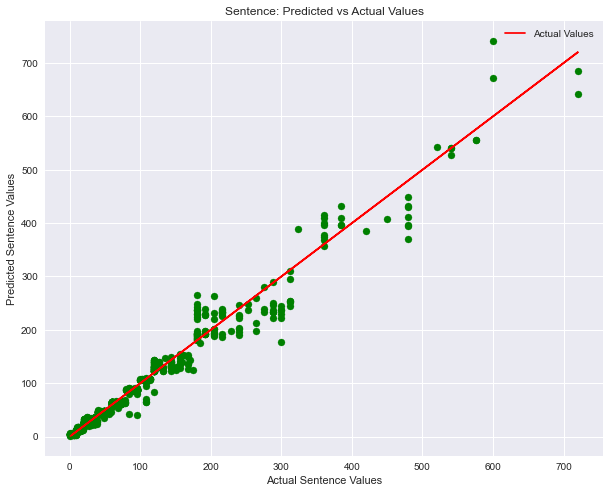

In [443]:
# Plot prediction vs actual
plt.figure(figsize = (10, 8))
plt.scatter(da.exp(y2_test.compute()), da.exp(preds_test3), c = 'g')
plt.plot(da.exp(y2_test.compute()), da.exp(y2_test.compute()), c = 'red', label = 'Actual Values')
plt.title('Sentence: Predicted vs Actual Values')
plt.xlabel('Actual Sentence Values')
plt.ylabel('Predicted Sentence Values')
plt.legend()
plt.show()

Will create a plot with features of importance

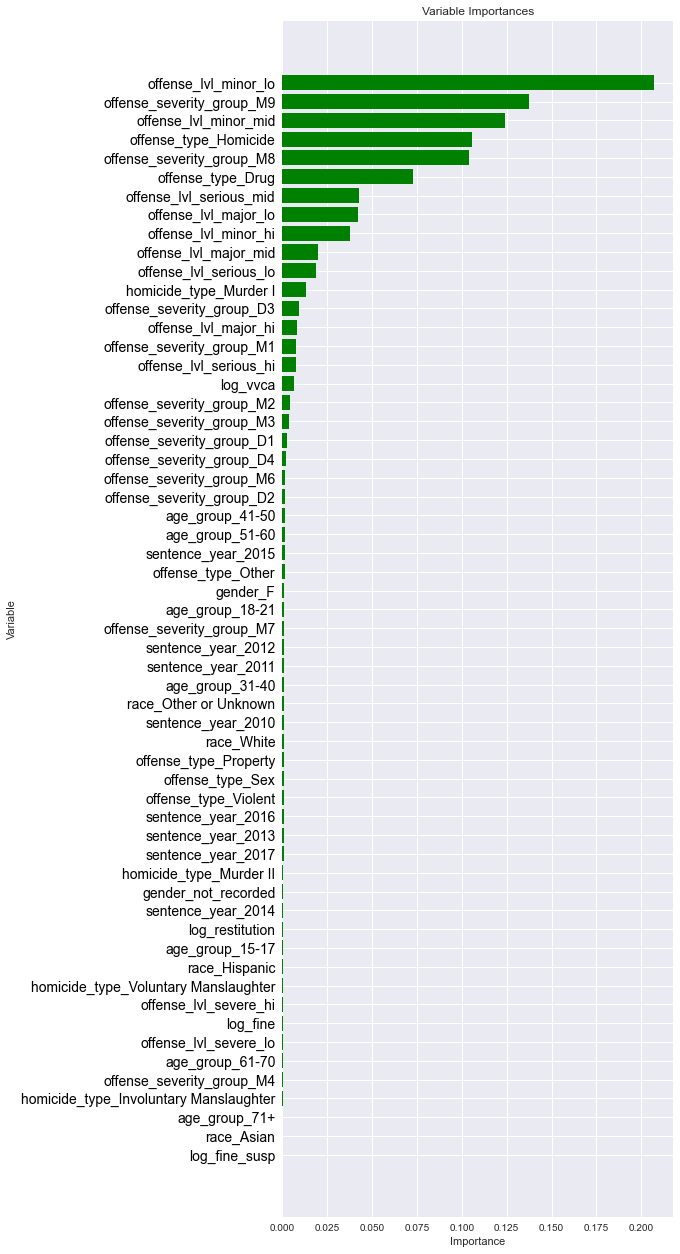

In [461]:
# Sorted feature importance plot
plt.figure(figsize = (7,22))
features = X2.columns
importances = rfr2.feature_importances_
feature_list = np.argsort(importances)

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.barh(range(len(feature_list)), importances[feature_list], align = 'center', color = 'g')
# Tick labels for x axis
plt.yticks(range(len(feature_list)), [features[i] for i in feature_list], size = 14, c = 'black')
# Axis labels and title
plt.ylabel('Variable'); plt.xlabel('Importance'); plt.title('Variable Importances')
plt.show()

In [574]:
# Close Connection
client.close()

**Results**

Random forest had a a slightly better explanation of variance on test sets consistently. Using Dask improved the run time for training using GridSearch and cross validation. 

Random Forest metrics are superior to those corresponding to the linear and XGBoost models in the study, making it the model of choice for this project.

The model’s primary intent was to achieve a high level of certainty in predicting a sentence for someone convicted of a crime in Washington DC. A secondary objective of the study was to investigate whether or not race is a factor in predicting a prison sentence. The primary objective was achieved by both models. One shortcoming found in the selected model as well as in the rest of the models created is that most of the errors in predictions are centered on the sentences of middle to higher lengths. There is also more balanced data required to be succesful in achieving the second objective. The dataset has a distribtuion of race that does not include a balanced number of variables.